In [1]:
import pandas as pd
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
import os

In [2]:
datasets = {
    'ds1': 'S07-hw-dataset-01.csv',
    'ds2': 'S07-hw-dataset-02.csv',
    'ds3': 'S07-hw-dataset-03.csv'
}

data_dict = {}
sample_ids = {}

for name, file in datasets.items():
    df = pd.read_csv(file)
    print(f"\n=== {name.upper()} ===")
    print(df.head())
    print(df.info())
    print(df.describe())
    print("Пропуски:\n", df.isnull().sum())
    print("Доли пропусков:\n", df.isnull().mean())

    sample_ids[name] = df['sample_id']
    X = df.drop(columns=['sample_id'])
    data_dict[name] = X


=== DS1 ===
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  floa

In [3]:
preprocessors = {}

for name, X in data_dict.items():
    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    if cat_features:
        from sklearn.preprocessing import OneHotEncoder
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), num_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
            ]
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), num_features)
            ]
        )

    preprocessors[name] = preprocessor

In [4]:
models_results = {}
best_models = {}

for name, X in data_dict.items():
    X_prep = preprocessors[name].fit_transform(X)
    models_results[name] = {}

    silhouettes_kmeans = []
    k_range = range(2, 21)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=22, n_init=10)
        labels = kmeans.fit_predict(X_prep)
        sil = silhouette_score(X_prep, labels)
        silhouettes_kmeans.append(sil)
    best_k = k_range[np.argmax(silhouettes_kmeans)]
    best_kmeans = KMeans(n_clusters=best_k, random_state=22, n_init=10).fit(X_prep)
    models_results[name]['KMeans'] = {
        'model': best_kmeans,
        'labels': best_kmeans.labels_,
        'silhouette_vs_k': (k_range, silhouettes_kmeans),
        'best_k': best_k
    }

    eps_range = np.linspace(0.1, 5.0, 50)
    silhouettes_dbscan = []
    noise_ratios = []
    best_eps = None
    best_sil = -2
    best_labels = None
    best_noise_ratio = None

    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_prep)
        noise_mask = labels == -1
        noise_ratio = noise_mask.mean()
        noise_ratios.append(noise_ratio)

        non_noise_labels = labels[~noise_mask]
        unique_labels = np.unique(non_noise_labels)
        n_clusters = len(unique_labels)

        if n_clusters < 2:
            sil = -1
        else:
            sil = silhouette_score(X_prep[~noise_mask], non_noise_labels)
        silhouettes_dbscan.append(sil)

        if sil > best_sil:
            best_sil = sil
            best_eps = eps
            best_labels = labels.copy()
            best_noise_ratio = noise_ratio

    if best_labels is None:
        best_labels = np.full(X_prep.shape[0], -1)
        best_noise_ratio = 1.0
        best_eps = eps_range[-1]

    models_results[name]['DBSCAN'] = {
        'model': DBSCAN(eps=best_eps, min_samples=5),
        'labels': best_labels,
        'silhouette_vs_eps': (eps_range, silhouettes_dbscan),
        'noise_ratio': best_noise_ratio,
        'best_eps': best_eps
    }

    linkages = ['ward', 'average']
    best_agg = None
    best_agg_sil = -1
    best_linkage = None
    best_k_agg = None

    for linkage in linkages:
        if linkage == 'ward':
            k_range_agg = range(2, min(21, X_prep.shape[0]))
        else:
            k_range_agg = range(2, 21)

        sils = []
        for k in k_range_agg:
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = agg.fit_predict(X_prep)
            sil = silhouette_score(X_prep, labels)
            sils.append(sil)
            if sil > best_agg_sil:
                best_agg_sil = sil
                best_agg = agg
                best_linkage = linkage
                best_k_agg = k

        models_results[name][f'Agg_{linkage}'] = {
            'silhouette_vs_k': (k_range_agg, sils),
            'best_k': best_k_agg
        }

    models_results[name]['Agglomerative'] = {
        'model': best_agg,
        'labels': best_agg.fit_predict(X_prep),
        'best_linkage': best_linkage,
        'best_k': best_k_agg
    }


In [5]:
metrics_summary = {}

for name, results in models_results.items():
    metrics_summary[name] = {}

    for model_name, res in results.items():
        if model_name in ['KMeans', 'Agglomerative']:
            labels = res['labels']
            sil = silhouette_score(preprocessors[name].fit_transform(data_dict[name]), labels)
            db = davies_bouldin_score(preprocessors[name].fit_transform(data_dict[name]), labels)
            ch = calinski_harabasz_score(preprocessors[name].fit_transform(data_dict[name]), labels)
            metrics_summary[name][model_name] = {
                'silhouette': sil,
                'davies_bouldin': db,
                'calinski_harabasz': ch
            }
        elif model_name == 'DBSCAN':
            labels = res['labels']
            noise_mask = labels == -1
            noise_ratio = res['noise_ratio']
            if noise_ratio < 1.0:
                X_non_noise = preprocessors[name].fit_transform(data_dict[name])[~noise_mask]
                labels_non_noise = labels[~noise_mask]
                sil = silhouette_score(X_non_noise, labels_non_noise)
                db = davies_bouldin_score(X_non_noise, labels_non_noise)
                ch = calinski_harabasz_score(X_non_noise, labels_non_noise)
            else:
                sil = db = ch = float('nan')
            metrics_summary[name][model_name] = {
                'silhouette': sil,
                'davies_bouldin': db,
                'calinski_harabasz': ch,
                'noise_ratio': noise_ratio
            }

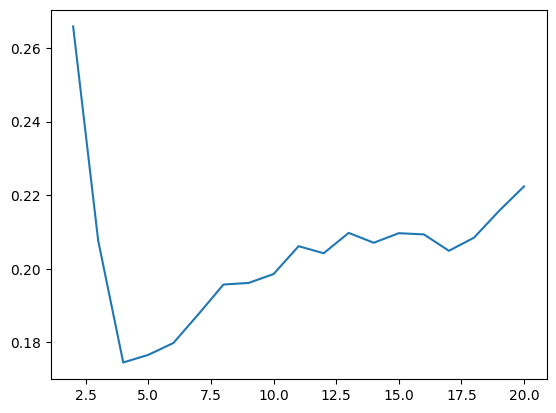

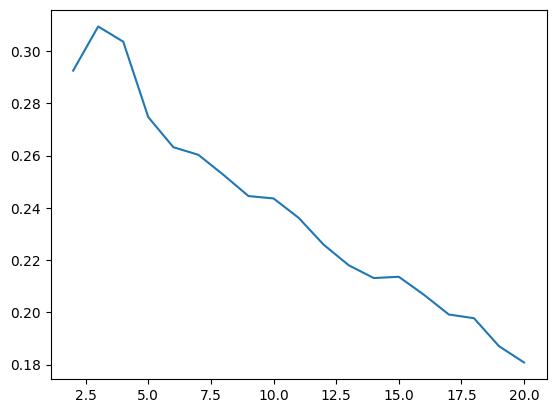

In [6]:
os.makedirs('figures', exist_ok=True)

for name, results in models_results.items():
    X_prep = preprocessors[name].fit_transform(data_dict[name])

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_prep)

    best_model_name = max(
        [(m, metrics_summary[name][m]['silhouette']) for m in metrics_summary[name]],
        key=lambda x: x[1] if not np.isnan(x[1]) else -np.inf
    )[0]
    best_labels = models_results[name][best_model_name]['labels']

    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab10', s=10)
    plt.title(f'{name.upper()} – PCA (Best: {best_model_name})')
    plt.savefig(f'figures/pca_{name}.png')
    plt.close()

    if best_model_name == 'KMeans':
        k_vals, sil_vals = results['KMeans']['silhouette_vs_k']
        plt.figure()
        plt.plot(k_vals, sil_vals, marker='o')
        plt.title(f'{name.upper()} – Silhouette vs k (KMeans)')
        plt.xlabel('k')
        plt.ylabel('Silhouette')
        plt.savefig(f'figures/sil_kmeans_{name}.png')
        plt.close()
    elif best_model_name == 'DBSCAN':
        eps_vals, sil_vals = results['DBSCAN']['silhouette_vs_eps']
        plt.figure()
        plt.plot(eps_vals, sil_vals)
        plt.title(f'{name.upper()} – Silhouette vs eps (DBSCAN)')
        plt.xlabel('eps')
        plt.ylabel('Silhouette')
        plt.savefig(f'figures/sil_dbscan_{name}.png')
        plt.close()
    elif best_model_name == 'Agglomerative':
        for linkage in ['ward', 'average']:
            if f'Agg_{linkage}' in results:
                k_vals, sil_vals = results[f'Agg_{linkage}']['silhouette_vs_k']
                plt.figure()
                plt.plot(k_vals, sil_vals, label=linkage)
        plt.title(f'{name.upper()} – Silhouette vs k (Agglomerative)')
        plt.xlabel('k')
        plt.ylabel('Silhouette')
        plt.legend()
        plt.savefig(f'figures/sil_agg_{name}.png')
        plt.close()

for name in ['ds1', 'ds2']:
    X_prep = preprocessors[name].fit_transform(data_dict[name])
    tsne = TSNE(n_components=2, random_state=22)
    X_tsne = tsne.fit_transform(X_prep)

    best_model_name = max(
        [(m, metrics_summary[name][m]['silhouette']) for m in metrics_summary[name]],
        key=lambda x: x[1] if not np.isnan(x[1]) else -np.inf
    )[0]
    best_labels = models_results[name][best_model_name]['labels']

    plt.figure(figsize=(6, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='tab10', s=10)
    plt.title(f'{name.upper()} – t-SNE (Best: {best_model_name}, random_state=22)')
    plt.savefig(f'figures/tsne_{name}.png')
    plt.close()

In [7]:
name = 'ds1'
X_prep = preprocessors[name].fit_transform(data_dict[name])
ari_scores = []

for rs in range(5):
    kmeans = KMeans(n_clusters=models_results[name]['KMeans']['best_k'], random_state=rs, n_init=10)
    labels = kmeans.fit_predict(X_prep)
    if rs == 0:
        ref_labels = labels
    else:
        ari_scores.append(adjusted_rand_score(ref_labels, labels))

print("ARI между запусками KMeans на ds1:", ari_scores)

ARI между запусками KMeans на ds1: [1.0, 1.0, 1.0, 1.0]


In [8]:
os.makedirs('artifacts', exist_ok=True)
os.makedirs('labels', exist_ok=True)

best_configs = {}

for name in data_dict.keys():
    best_model_name = max(
        [(m, metrics_summary[name][m]['silhouette']) for m in metrics_summary[name]],
        key=lambda x: x[1] if not np.isnan(x[1]) else -np.inf
    )[0]

    best_labels = models_results[name][best_model_name]['labels']

    pd.DataFrame({
        'sample_id': sample_ids[name],
        'cluster_label': best_labels
    }).to_csv(f'labels/labels_hw07_{name}.csv', index=False)

    cfg = {'model': best_model_name}
    if best_model_name == 'KMeans':
        cfg['n_clusters'] = models_results[name]['KMeans']['best_k']
    elif best_model_name == 'DBSCAN':
        cfg['eps'] = models_results[name]['DBSCAN']['best_eps']
        cfg['min_samples'] = 5
        cfg['noise_ratio'] = models_results[name]['DBSCAN']['noise_ratio']
    elif best_model_name == 'Agglomerative':
        cfg['n_clusters'] = models_results[name]['Agglomerative']['best_k']
        cfg['linkage'] = models_results[name]['Agglomerative']['best_linkage']

    best_configs[name] = cfg

with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

for name in data_dict.keys():
    best_model = best_configs[name]['model']
    print(f"\n=== ИТОГ ПО {name.upper()} ===")
    print(f"Лучший метод: {best_model}")


=== ИТОГ ПО DS1 ===
Лучший метод: KMeans

=== ИТОГ ПО DS2 ===
Лучший метод: Agglomerative

=== ИТОГ ПО DS3 ===
Лучший метод: Agglomerative
